In [5]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

python(99621) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [7]:
!pip install pyspark

python(99635) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 2.6 MB/s eta 0:00:00ta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=685b97c09d5bf9ee911736884b44ffc463af575730990e00d132073130e23034
  Stored in directory: /Users/purbaksengupta/Library/Caches/pip/wheels/95/13/41/f7f135ee114175605fb4f0a89e7389f3742aa6c1e1a5bcb657
Successfully built pyspark


In [8]:
import pyspark.sql.functions as f
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Time Series analysis').getOrCreate()

python(99802) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/09 12:17:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/09 12:17:59 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [11]:
df = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/users/purbaksengupta/downloads/train.csv')
df.limit(3).toPandas().style.hide(axis="index")

Store,Dept,Date,Weekly_Sales,IsHoliday
1,1,2010-02-05,24924.500000,False
1,1,2010-02-12,46039.490000,True
1,1,2010-02-19,41595.550000,False


In [12]:
mn_dt = df.select('Date').agg(f.min('Date')).collect()[0][0]
mx_dt = df.select('Date').agg(f.max('Date')).collect()[0][0]
print('Total Rows: ',df.count())
print('Min Date: ', mn_dt)
print('Max Date: ', mx_dt)

Total Rows:  421570
Min Date:  2010-02-05
Max Date:  2012-10-26


In [14]:
stores = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/users/purbaksengupta/downloads/stores.csv')
stores.limit(3).toPandas().style.hide(axis="index")

Store,Type,Size
1,A,151315
2,A,202307
3,B,37392


In [15]:
print('Total Rows: ', stores.count())
print('Total Stores: ', stores.select('Store').distinct().count())
stores.select('Type').distinct().show()

Total Rows:  45
Total Stores:  45
+----+
|Type|
+----+
|   B|
|   C|
|   A|
+----+



In [16]:
features = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/users/purbaksengupta/downloads/features.csv')
features.limit(3).toPandas().style.hide(axis="index")

Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
1,2010-02-05,42.310000,2.572000,NA,NA,NA,NA,NA,211.0963582,8.106,False
1,2010-02-12,38.510000,2.548000,NA,NA,NA,NA,NA,211.2421698,8.106,True
1,2010-02-19,39.930000,2.514000,NA,NA,NA,NA,NA,211.2891429,8.106,False


In [17]:
mn_dt = features.select('Date').agg(f.min('Date')).collect()[0][0]
mx_dt = features.select('Date').agg(f.max('Date')).collect()[0][0]
print('Total Rows: ',features.count())
print('Min Date: ', mn_dt)
print('Max Date: ', mx_dt)

Total Rows:  8190
Min Date:  2010-02-05
Max Date:  2013-07-26


In [18]:
for i in range(1,6):
    features = features.withColumn(
        f'MarkDown{i}', f.when(f.col(f'MarkDown{i}')=='NA', None).otherwise(
            f.col(f'MarkDown{i}')).cast('float'))

In [19]:
pdf = df.join(
    stores, on='Store', how='inner').join(
    features.drop('IsHoliday'), on=['Date','Store'], how='left').toPandas()
pdf['Date'] = pd.to_datetime(pdf['Date'])
pdf.set_index('Date', inplace=True)
pdf["CPI"] = pd.to_numeric(pdf["CPI"], downcast="float")
pdf["Unemployment"] = pd.to_numeric(pdf["Unemployment"], downcast="float")
pdf.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096359,8.106
2010-02-12,1,1,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242172,8.106
2010-02-19,1,1,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289139,8.106
2010-02-26,1,1,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319641,8.106
2010-03-05,1,1,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [20]:
pdf.dtypes

Store             int32
Dept              int32
Weekly_Sales    float64
IsHoliday          bool
Type             object
Size              int32
Temperature     float64
Fuel_Price      float64
MarkDown1       float32
MarkDown2       float32
MarkDown3       float32
MarkDown4       float32
MarkDown5       float32
CPI             float32
Unemployment    float32
dtype: object

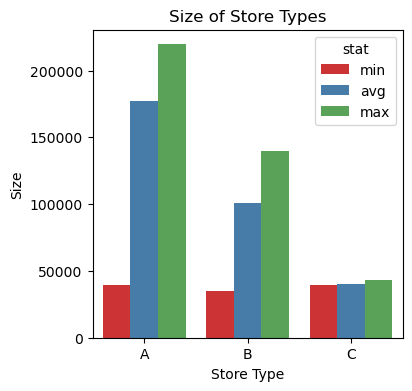

In [21]:
# Checking min, max, average of store by Type
stdf = stores.groupBy('Type').agg(
    f.min('Size').alias('min'), 
    f.round(f.avg('Size'),2).alias('avg'), 
    f.max('Size').alias('max')).orderBy('Type').toPandas()

m_df = pd.melt(stdf, id_vars="Type", var_name="stat", value_name="Size")
fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(x='Type', y='Size', hue='stat', data=m_df, ax=ax, palette='Set1').set_title('Size of Store Types')
plt.xlabel('Store Type')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


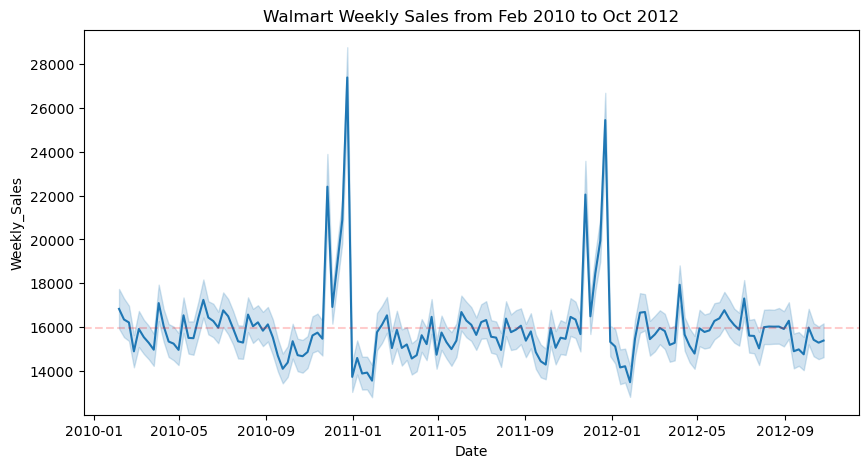

In [22]:
plt.figure(figsize=(10,5))
sns.lineplot(data=pdf, 
             x='Date', 
             y='Weekly_Sales',
            ).set_title('Walmart Weekly Sales from Feb 2010 to Oct 2012')
plt.axhline(pdf['Weekly_Sales'].mean(), color='r', alpha=0.2, linestyle='--')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


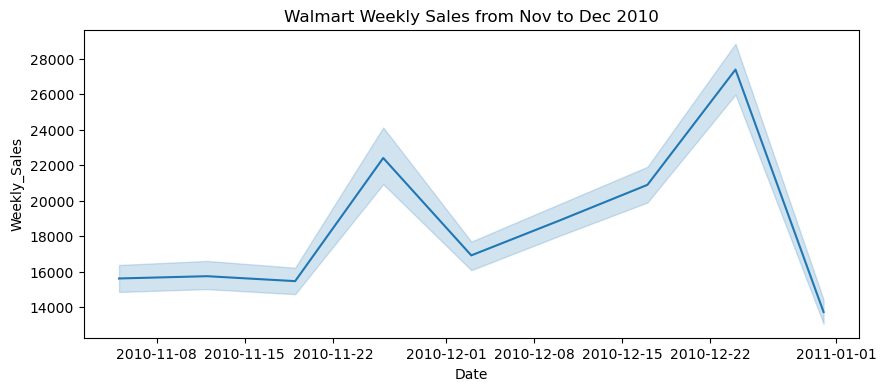

In [23]:
plt.figure(figsize=(10,4))
sns.lineplot(
    data=pdf.loc[(pdf.index >'2010-11-01') & (pdf.index<'2011-01-01')], 
    x='Date', y='Weekly_Sales'
    ).set_title('Walmart Weekly Sales from Nov to Dec 2010')
plt.show()

In [24]:
pdf['Day'] = pdf.index.day
pdf['Month'] = pdf.index.month
pdf['Quarter'] = pdf.index.quarter
pdf['Year'] = pdf.index.year

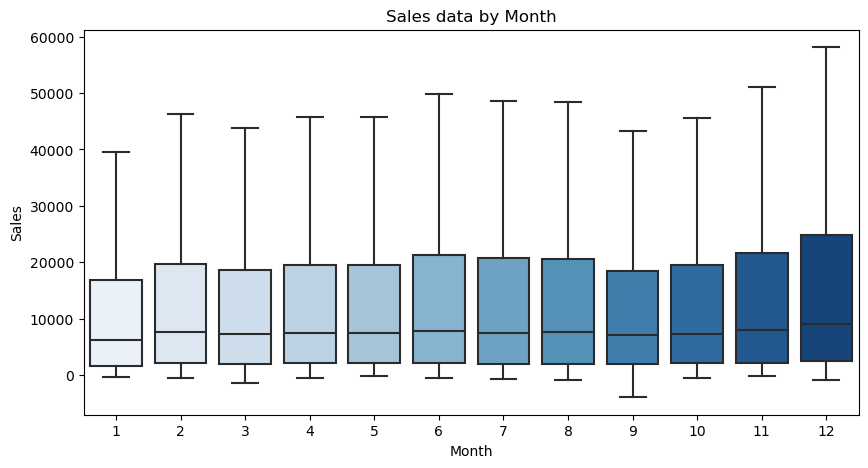

In [25]:
plt.figure(figsize=(10,5))
sns.boxplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')], x='Month', y='Weekly_Sales', 
            palette='Blues', showfliers=False
           ).set_title('Sales data by Month')
plt.ylabel('Sales')
plt.show()

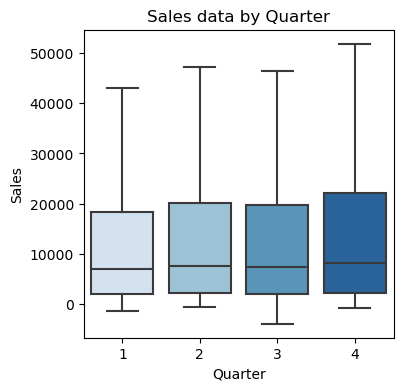

In [26]:
plt.figure(figsize=(4,4))
sns.boxplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')], x='Quarter', y='Weekly_Sales', 
            palette='Blues', showfliers=False
           ).set_title('Sales data by Quarter')
plt.ylabel('Sales')
plt.show()

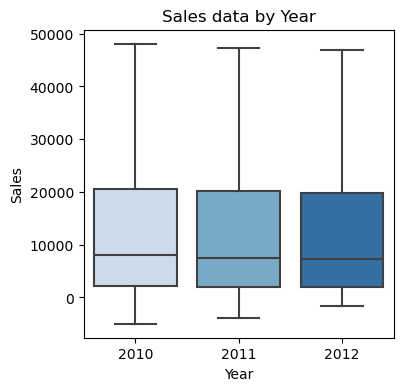

In [27]:
plt.figure(figsize=(4,4))
sns.boxplot(data=pdf, x='Year', y='Weekly_Sales', 
            palette='Blues', showfliers=False
           ).set_title('Sales data by Year')
plt.ylabel('Sales')
plt.show()

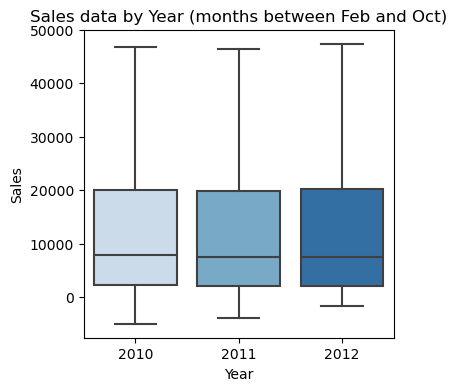

In [28]:
plt.figure(figsize=(4,4))
sns.boxplot(data=pdf.loc[pdf.index.month.isin([2,3,4,5,6,7,8,9,10])], x='Year', y='Weekly_Sales', 
            palette='Blues', showfliers=False
           ).set_title('Sales data by Year (months between Feb and Oct)')
plt.ylabel('Sales')
plt.show()

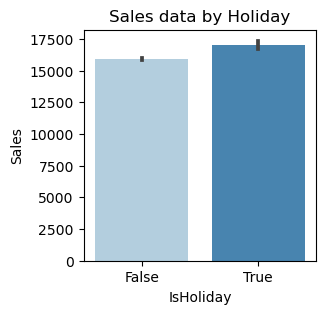

In [29]:
plt.figure(figsize=(3,3))
sns.barplot(data=pdf, x='IsHoliday', y='Weekly_Sales', 
            palette='Blues', #showfliers=False
           ).set_title('Sales data by Holiday')
plt.ylabel('Sales')
plt.show()

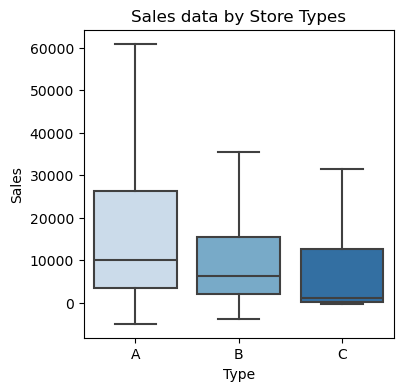

In [30]:
plt.figure(figsize=(4,4))
sns.boxplot(data=pdf, x='Type', y='Weekly_Sales', 
            palette='Blues' , showfliers=False
           ).set_title('Sales data by Store Types')
plt.ylabel('Sales')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


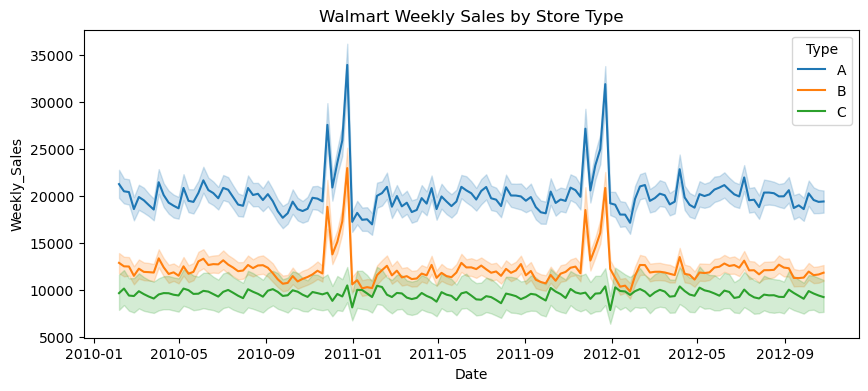

In [31]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf, 
             x='Date', 
             y='Weekly_Sales',
             hue='Type'
            ).set_title('Walmart Weekly Sales by Store Type')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


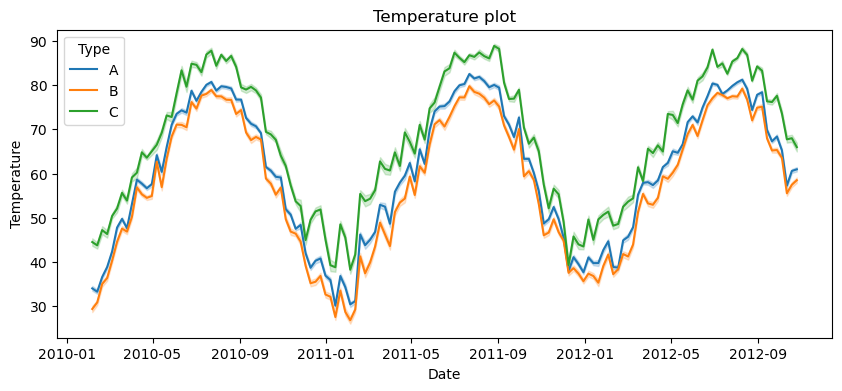

In [32]:
fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(data=pdf, 
             x='Date', 
             y='Temperature',
             hue='Type',
             ax=ax,
            ).set_title('Temperature plot')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


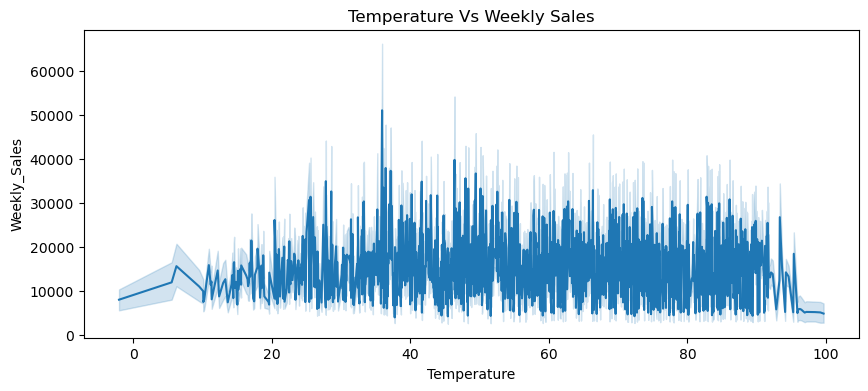

In [33]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')], 
             x='Temperature', 
             y='Weekly_Sales',
            ).set_title('Temperature Vs Weekly Sales')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


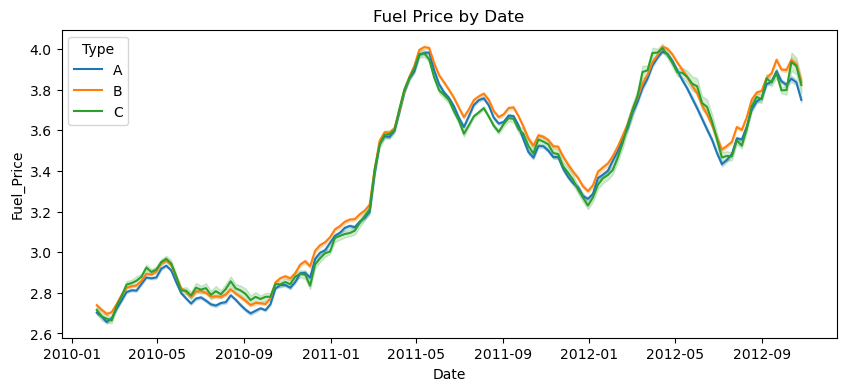

In [34]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf, 
             x='Date', 
             y='Fuel_Price',
             hue='Type',
            ).set_title('Fuel Price by Date')
plt.show()

In [35]:
pdf['Fuel_Price_Change'] = pdf['Fuel_Price'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


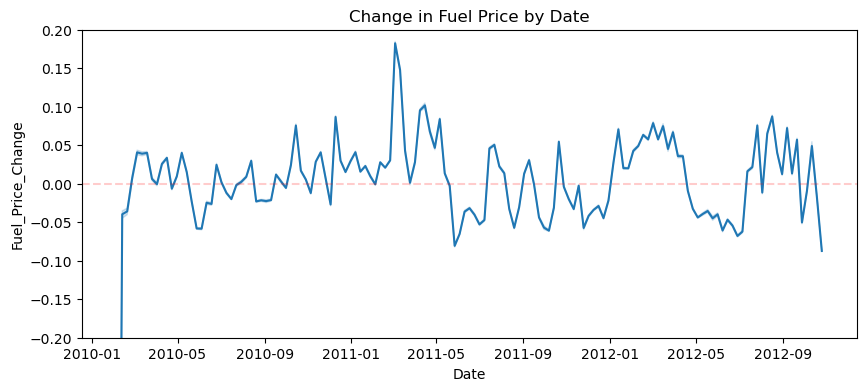

In [36]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf, 
             x='Date', 
             y='Fuel_Price_Change',
             #hue='Type',
            ).set_title('Change in Fuel Price by Date')
plt.axhline(pdf['Fuel_Price_Change'].mean(), color='r', alpha=0.2, linestyle='--')
plt.ylim(-0.2, 0.2)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


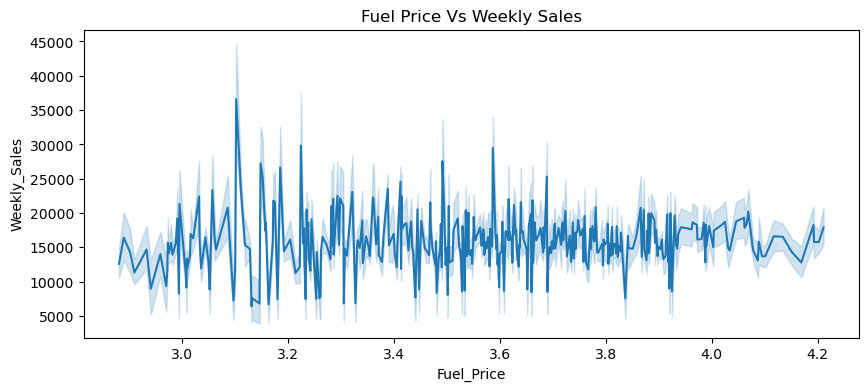

In [37]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf.loc[(pdf.index >'2011-01-01') & (pdf.index<'2011-12-31')], 
             x='Fuel_Price', 
             y='Weekly_Sales',
            ).set_title('Fuel Price Vs Weekly Sales')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


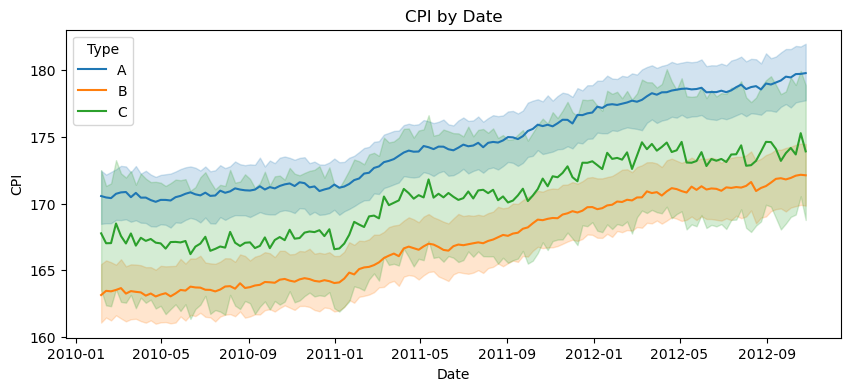

In [38]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf, 
             x='Date', 
             y='CPI',
             hue='Type'
            ).set_title('CPI by Date')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


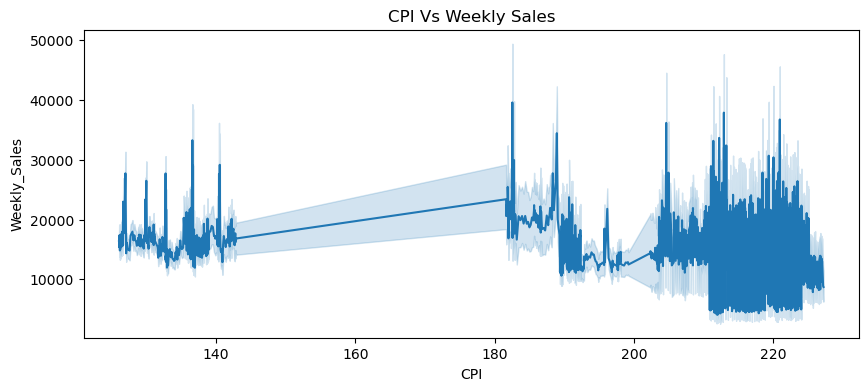

In [39]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf, 
             x='CPI', 
             y='Weekly_Sales',
            ).set_title('CPI Vs Weekly Sales')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


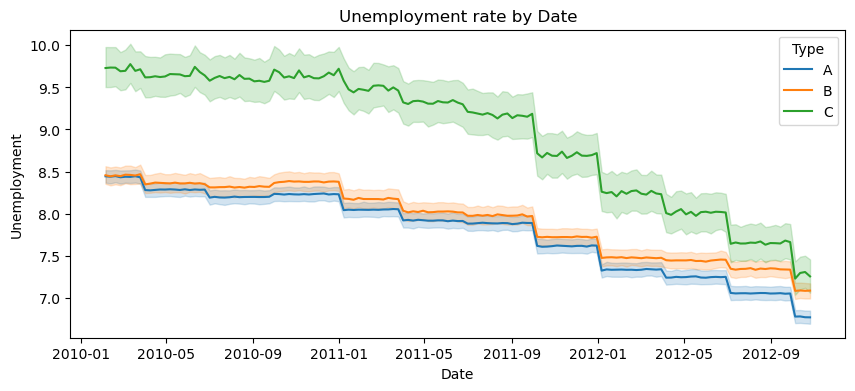

In [40]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf, 
             x='Date', 
             y='Unemployment',
             hue='Type',
            ).set_title('Unemployment rate by Date')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


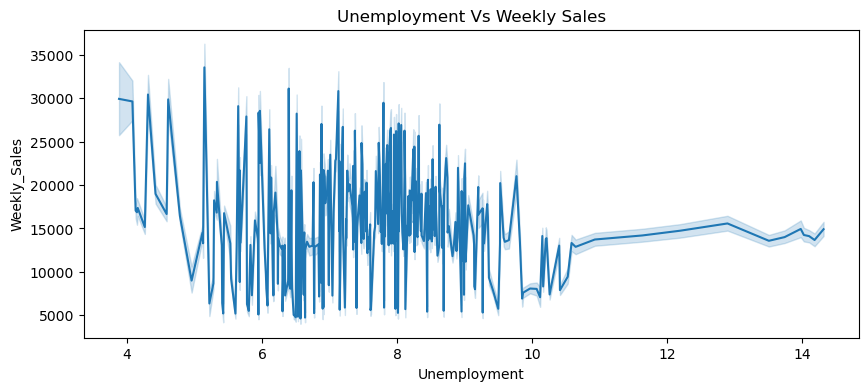

In [41]:
plt.figure(figsize=(10,4))
sns.lineplot(data=pdf, 
             x='Unemployment', 
             y='Weekly_Sales',
            ).set_title('Unemployment Vs Weekly Sales')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):


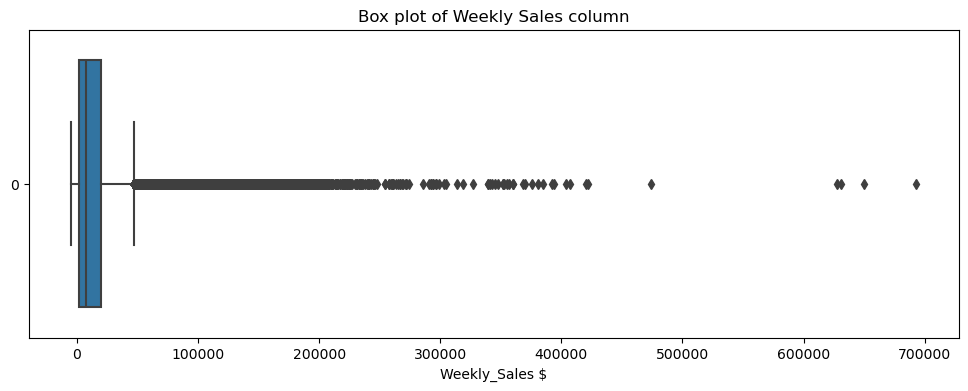

In [42]:
plt.figure(figsize=(12,4))
sns.boxplot(pdf['Weekly_Sales'], orient='h')
plt.xlabel('Weekly_Sales $')
plt.title('Box plot of Weekly Sales column')
plt.show()

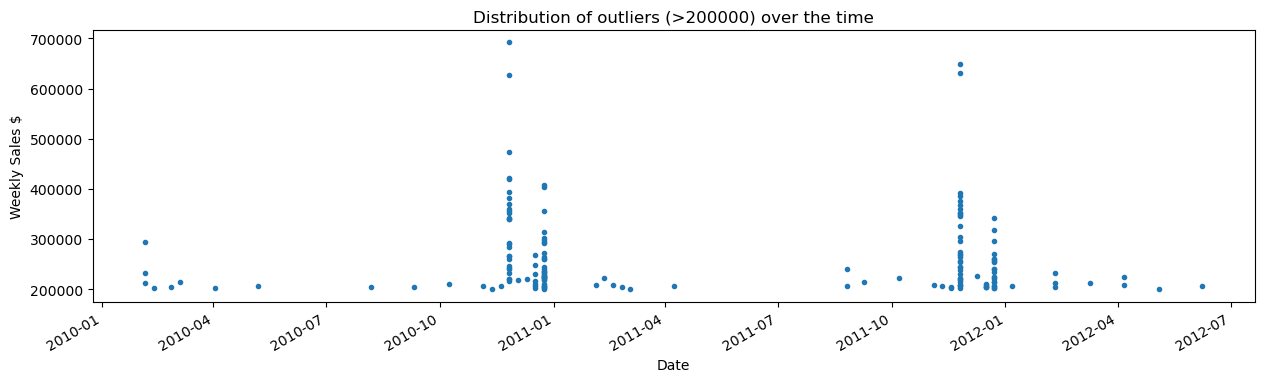

In [43]:
pdf.query('Weekly_Sales > 200000')['Weekly_Sales'].plot(figsize=(15,4), style='.')
plt.ylabel('Weekly Sales $')
plt.title('Distribution of outliers (>200000) over the time')
plt.show()

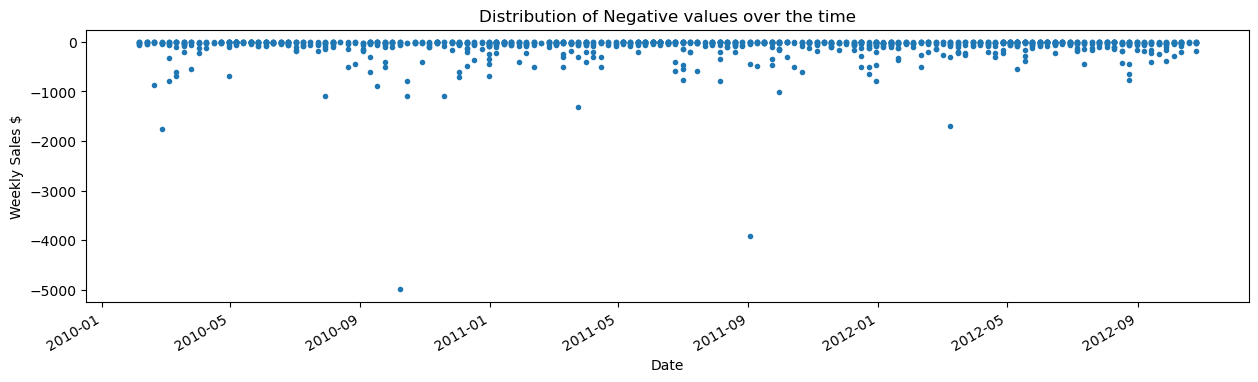

In [44]:
pdf.query('Weekly_Sales < 0')['Weekly_Sales'].plot(figsize=(15,4), style='.')
plt.ylabel('Weekly Sales $')
plt.title('Distribution of Negative values over the time')
plt.show()

In [45]:
old_count = pdf.shape[0]
print('Dataset_size before removing outliers: ', old_count)
pdf = pdf.query('Weekly_Sales >= 0 and Weekly_Sales < 200000')
new_count = pdf.shape[0]
print('Dataset_size after removing outliers: ', pdf.shape[0])
print('Percent decrease in data: ', round((old_count - new_count)*100/old_count,2))

Dataset_size before removing outliers:  421570
Dataset_size after removing outliers:  420122
Percent decrease in data:  0.34


/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


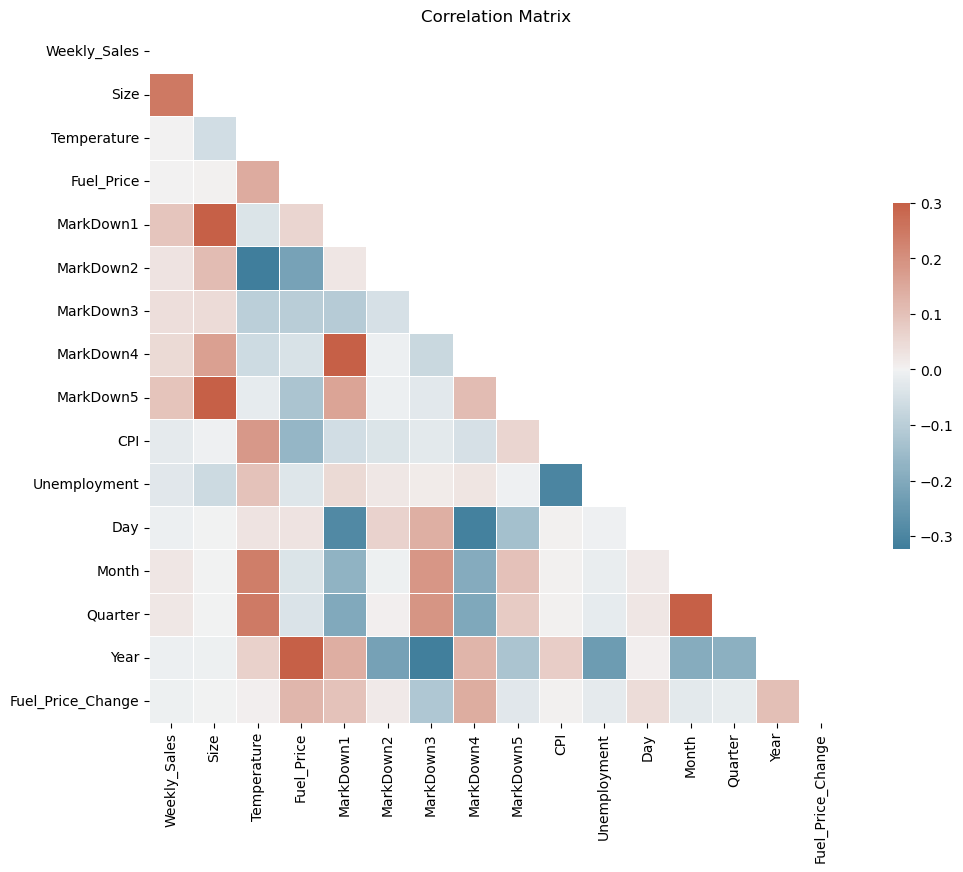

In [47]:
# Numerical cols
num_cols = [x for x in pdf.columns if x not in ['Type','IsHoliday','Dept','Store']]

# Compute the correlation matrix
corr = pdf[num_cols].corr().round(3)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix')
plt.show()

In [48]:
!pip install xgboost

python(9328) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.4 MB/s eta 0:00:0000:0100:01


In [51]:
from pyspark.sql import functions as F

df = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/users/purbaksengupta/downloads/train.csv')
stores = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/users/purbaksengupta/downloads/stores.csv')
features = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/users/purbaksengupta/downloads/features.csv')

# Converting 'NA' strings in MarkDown columns to null values
for i in range(1, 6):
    features = features.withColumn(
        f'MarkDown{i}', F.when(F.col(f'MarkDown{i}') == 'NA', None).otherwise(
            F.col(f'MarkDown{i}')).cast('float')
    )

pdf = df.join(
    stores, on='Store', how='inner'
).join(
    features.drop('IsHoliday'), on=['Date','Store'], how='left'
).toPandas()

pdf['Date'] = pd.to_datetime(pdf['Date'])
pdf.set_index('Date', inplace=True)
pdf["CPI"] = pd.to_numeric(pdf["CPI"], downcast="float")
pdf["Unemployment"] = pd.to_numeric(pdf["Unemployment"], downcast="float")
pdf['Day'] = pdf.index.day
pdf['Week'] = np.ceil(pdf.index.dayofyear/7).astype(int)
pdf['Month'] = pdf.index.month
pdf['Quarter'] = pdf.index.quarter
pdf['Year'] = pdf.index.year

pdf = pdf.query('Weekly_Sales >= 0 and Weekly_Sales < 200000')
pdf.head().style.hide(axis="index")


Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Day,Week,Month,Quarter,Year
1,1,24924.500000,False,A,151315,42.310000,2.572000,nan,nan,nan,nan,nan,211.096359,8.106000,5,6,2,1,2010
1,1,46039.490000,True,A,151315,38.510000,2.548000,nan,nan,nan,nan,nan,211.242172,8.106000,12,7,2,1,2010
1,1,41595.550000,False,A,151315,39.930000,2.514000,nan,nan,nan,nan,nan,211.289139,8.106000,19,8,2,1,2010
1,1,19403.540000,False,A,151315,46.630000,2.561000,nan,nan,nan,nan,nan,211.319641,8.106000,26,9,2,1,2010
1,1,21827.900000,False,A,151315,46.500000,2.625000,nan,nan,nan,nan,nan,211.350143,8.106000,5,10,3,1,2010


In [52]:
pdf.isnull().sum()

Store                0
Dept                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       269992
MarkDown2       309270
MarkDown3       283525
MarkDown4       285656
MarkDown5       269244
CPI                  0
Unemployment         0
Day                  0
Week                 0
Month                0
Quarter              0
Year                 0
dtype: int64

In [53]:
pdf.fillna(0, inplace=True)

In [54]:
# Converting Is Holiday column to int
# Changing the type will replace True -> 1 and False -> 0
pdf['IsHoliday'] = pdf['IsHoliday'].astype('int')

In [55]:
# Converting Type of store into numerical
# We will use the order of size to decide the numerical values for store types
# As we have seen Type A stores are largest and C are smallest, 
# we will use the following mapping
# C-> 0, B-> 1, A-> 2

pdf['Type'] = pdf['Type'].replace({'C': 0, 'B': 1, 'A': 2})

In [56]:
TARGET = ['Weekly_Sales']
FEATURES = [i for i in pdf.columns if i not in TARGET]

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pdf[FEATURES], pdf[TARGET],
                                                   test_size=0.2, random_state=130)

In [58]:
import xgboost as xgb
reg = xgb.XGBRegressor(n_estimators=2000, early_stopping_rounds=50,
                      learning_rate=0.5)
model = reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:15063.79170	validation_1-rmse:15139.93328
[100]	validation_0-rmse:4242.24583	validation_1-rmse:4492.70623
[200]	validation_0-rmse:3482.17459	validation_1-rmse:3878.64994
[300]	validation_0-rmse:3087.08542	validation_1-rmse:3587.85615
[400]	validation_0-rmse:2811.11912	validation_1-rmse:3408.92916
[500]	validation_0-rmse:2608.76790	validation_1-rmse:3287.69013
[600]	validation_0-rmse:2453.39392	validation_1-rmse:3205.62576
[700]	validation_0-rmse:2334.43202	validation_1-rmse:3135.30009
[800]	validation_0-rmse:2237.46742	validation_1-rmse:3089.50207
[900]	validation_0-rmse:2146.26464	validation_1-rmse:3049.58338
[1000]	validation_0-rmse:2069.41808	validation_1-rmse:3019.87896
[1100]	validation_0-rmse:2000.64612	validation_1-rmse:2989.92329
[1200]	validation_0-rmse:1937.12835	validation_1-rmse:2962.81252
[1300]	validation_0-rmse:1882.34812	validation_1-rmse:2942.05732
[1400]	validation_0-rmse:1837.24162	validation_1-rmse:2926.77431
[1500]	validation_0-rmse:1783.89858

In [60]:
y_pred = reg.predict(X_test)

In [62]:
from sklearn import metrics
xgboost_accuracy = reg.score(X_test,y_test)*100
print("XGB Regressor Evaluation Metrics: ")
print("Accuracy", round(xgboost_accuracy,3))
print("MAE \t" , round(metrics.mean_absolute_error(y_test, y_pred),3))
print("MSE \t" , round(metrics.mean_squared_error(y_test, y_pred),3))
print("RMSE \t" , round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3))
print("R2 \t" , round(metrics.explained_variance_score(y_test, y_pred),5))

XGB Regressor Evaluation Metrics: 
Accuracy 98.348
MAE 	 1570.744
MSE 	 8134464.931
RMSE 	 2852.098
R2 	 0.98348


In [63]:
print('Top 10 features with their Feature importance scores: ')
pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['Feature Importance']).sort_values('Feature Importance', ascending=False).head(10)

Top 10 features with their Feature importance scores: 


,Feature Importance
Size,0.349576
Dept,0.214630
Type,0.146933
Store,0.098718
CPI,0.038189
Week,0.030618
IsHoliday,0.024891
Month,0.023361
Year,0.019829
Unemployment,0.011220


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

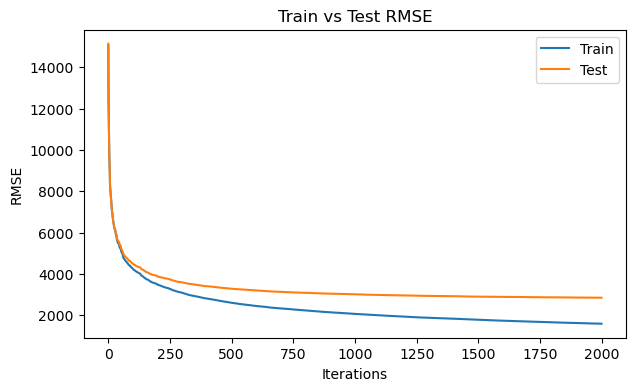

In [64]:
fig, ax = plt.subplots(1,1,figsize=(7,4))
score_hist = pd.DataFrame({'Train_rmse':model.evals_result()['validation_0']['rmse'], 'Test_rmse':model.evals_result()['validation_1']['rmse']})
sns.lineplot(score_hist['Train_rmse'], ax=ax, label='Train')
sns.lineplot(score_hist['Test_rmse'], ax=ax, label='Test')
plt.ylabel('RMSE')
plt.xlabel('Iterations')
plt.title('Train vs Test RMSE')
plt.show()

In [65]:
val = pdf.loc[pdf.index >= '2012-05-01']
X_val, y_val = val[FEATURES], val[TARGET]
val['prediction'] = reg.predict(X_val)

/var/folders/wg/5j0c1cb973vghyvjwtv_f8qw0000gn/T/ipykernel_4934/2158810898.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['prediction'] = reg.predict(X_val)


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

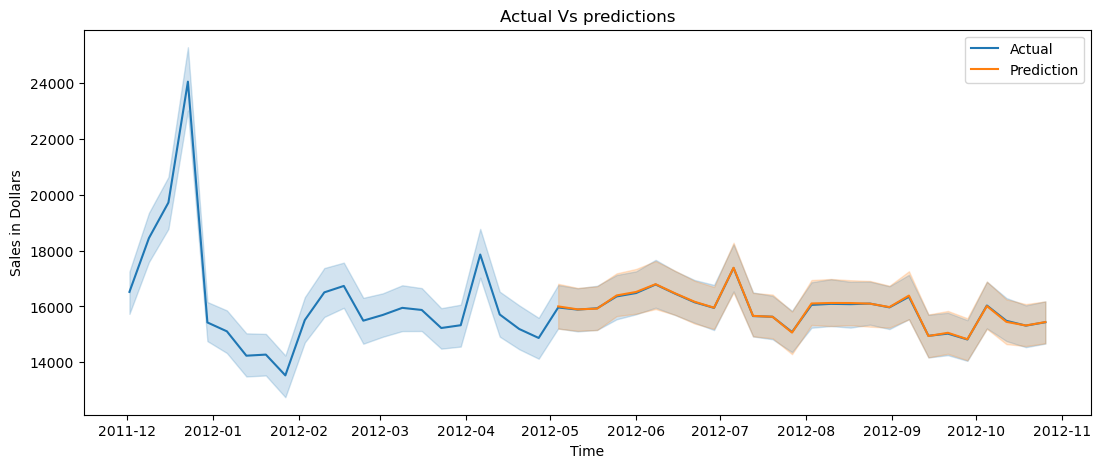

In [66]:
fig, ax = plt.subplots(1,1,figsize=(13,5))
sns.lineplot(pdf['Weekly_Sales'].loc[pdf.index>'2011-12-01'], ax=ax, label='Actual')
sns.lineplot(val['prediction'], ax=ax, label='Prediction')
plt.ylabel('Sales in Dollars')
plt.xlabel('Time')
plt.title('Actual Vs predictions')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


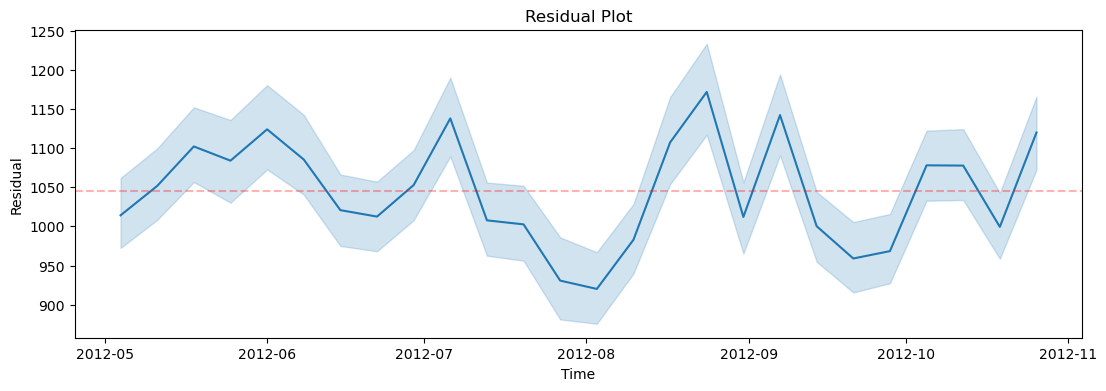

In [67]:
val = val.assign(Residual= abs(val['Weekly_Sales'] - val['prediction']))
fig, ax = plt.subplots(1,1,figsize=(13,4))
#sns.lineplot(pdf['Weekly_Sales'].loc[pdf.index>'2011-12-01'], ax=ax, label='Actual')
sns.lineplot(val['Residual'], ax=ax)
plt.axhline(val['Residual'].mean(), linestyle='--', color='r', alpha=0.3)
#plt.ylabel('Sales in Dollars')
plt.xlabel('Time')
plt.title('Residual Plot')
plt.show()

In [68]:
cum_pdf = pdf['Weekly_Sales'].groupby('Date').sum().to_frame(name='Weekly_Sales')

In [69]:
train = cum_pdf.loc[cum_pdf.index < '2012-05-01']
test = cum_pdf.loc[cum_pdf.index >= '2012-05-01']

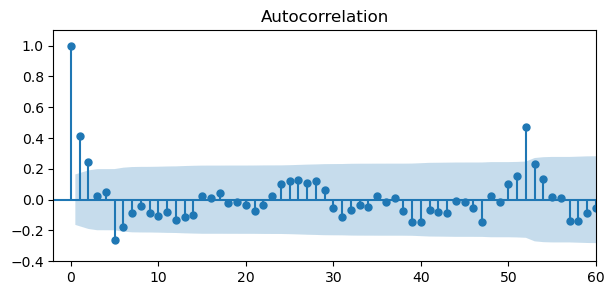

In [70]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(7,3))
acf_plot = plot_acf(cum_pdf.Weekly_Sales, lags=100, ax=ax)
plt.ylim(-0.4, 1.1)
plt.xlim(-2,60)
plt.show()

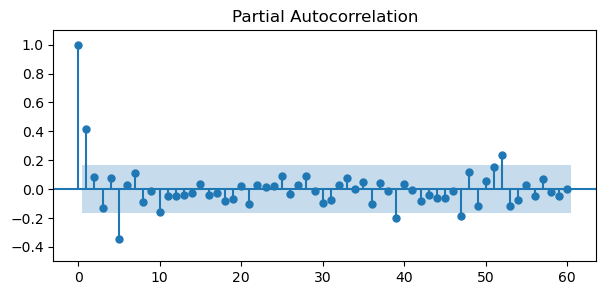

In [71]:
fig, ax = plt.subplots(figsize=(7,3))
pacf_plot = plot_pacf(cum_pdf.Weekly_Sales, lags=60, ax=ax)
plt.ylim(-0.5, 1.1)
plt.show()

In [72]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(cum_pdf.Weekly_Sales)   
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.357042012534242
p-value: 2.5278147982296737e-08


In [73]:
import statsmodels.api as sm
order_aic_bic =[]

# Loop over p values from 0-2
for p in [1,2,5,52]:
    # Loop over q values from 0-2
    for q in [1,2,5,52]:
      
        try:
            # create and fit ARMA(p,q) model
            model = sm.tsa.statespace.SARIMAX(train.Weekly_Sales, order=(p, 0, q))
            results = model.fit(maxiter=100, full_output=False, disp=False)
            
            # Print order and results
            order_aic_bic.append((p, q, results.aic, results.bic))            
        except:
            print(p, q, None, None)
            
# Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'aic','bic'])

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency informat

In [74]:
# lets sort them by AIC and BIC

# Sort by AIC
print("Sorting SARIMA model with different (p,q) by AIC ")
print("\n")
print(order_df.sort_values('aic').reset_index(drop=True))

# Sort by BIC
print("Sorted by BIC ")
print("\n")
print(order_df.sort_values('bic').reset_index(drop=True))

Sorting SARIMA model with different (p,q) by AIC 


     p   q          aic          bic
0    2   5    16.000000    38.097391
1   52   5  3879.078222  4039.284310
2   52   2  3882.493598  4034.413164
3   52   1  3882.575246  4031.732639
4    1   5  3920.531866  3939.867083
5    5   5  3925.572242  3955.956156
6    2   1  3930.915416  3941.964111
7    1   2  3937.795438  3948.844134
8    5   2  3939.889030  3961.986422
9    5   1  3942.014748  3961.349966
10   1   1  3942.865561  3951.152083
11   2   2  3945.281683  3959.092553
12   1  52  3981.262006  4130.419398
13   2  52  3982.628197  4134.547763
14   5  52  4001.086185  4161.292273
15  52  52  4060.919280  4350.947543
Sorted by BIC 


     p   q          aic          bic
0    2   5    16.000000    38.097391
1    1   5  3920.531866  3939.867083
2    2   1  3930.915416  3941.964111
3    1   2  3937.795438  3948.844134
4    1   1  3942.865561  3951.152083
5    5   5  3925.572242  3955.956156
6    2   2  3945.281683  3959.092553
7    5

In [75]:
# The model with the best p and q found from pervious step
import statsmodels.api as sm
model = sm.tsa.statespace.SARIMAX(train.Weekly_Sales, order=(52, 0, 5))
# Fit model
results = model.fit()
# Assign residuals to variable
residuals = results.resid

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           58     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.72251D+02    |proj g|=  8.98967D+02

At iterate    5    f=  2.19392D+01    |proj g|=  4.95783D+00

At iterate   10    f=  1.67367D+01    |proj g|=  1.15256D+00

At iterate   15    f=  1.62973D+01    |proj g|=  3.05476D-01

At iterate   20    f=  1.62719D+01    |proj g|=  8.10851D-02

At iterate   25    f=  1.62507D+01    |proj g|=  1.37833D-01

At iterate   30    f=  1.62038D+01    |proj g|=  3.14710D-01

At iterate   35    f=  1.61689D+01    |proj g|=  6.96880D-02

At iterate   40    f=  1.61619D+01    |proj g|=  6.27085D-02

At iterate   45    f=  1.61509D+01    |proj g|=  6.72457D-02

At iterate   50    f=  1.61389D+01    |proj g|=  1.27262D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [76]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  117
Model:              SARIMAX(52, 0, 5)   Log Likelihood               -1888.252
Date:                Thu, 09 May 2024   AIC                           3892.504
Time:                        14:47:56   BIC                           4052.710
Sample:                    02-05-2010   HQIC                          3957.546
                         - 04-27-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0093      0.114      0.082      0.935      -0.214       0.233
ar.L2          0.0339      0.104      0.325      0.745      -0.171       0.238
ar.L3         -0.0222      0.102     -0.217      0.828      -0.223       0.178
ar.L4         -0.0244      0.112     -0.218      0.827      -0.243       0.195
ar.L5         -0.0191      0.067     -0.284      0.777      -0.151       0.113
ar.L6         -0.0911      0.078     -1.162      0.245      -0.245       0.063
ar.L7          0.0899      0.079      1.139      0.255      -0.065       0.245
ar.L8         -0.0354      0.095     -0.371      0.710      -0.223       0.152
ar.L9         -0.0664      0.089     -0.747      0.455      -0.241       0.108
ar.L10         0.0419      0.080      0.525      0.600      -0.115       0.198
ar.L11        -0.0525      0.073     -0.722      0.470      -0.195       0.090
ar.L12         0.0870      0.089      0.982      0.326      -0.087       0.261
ar.L13        -0.0087      0.075     -0.115      0.908      -0.156       0.139
ar.L14        -0.1021      0.088     -1.161      0.246      -0.274       0.070
ar.L15         0.1069      0.072      1.482      0.138      -0.034       0.248
ar.L16         0.0335      0.074      0.450      0.653      -0.112       0.179
ar.L17         0.0280      0.076      0.371      0.711      -0.120       0.176
ar.L18         0.0063      0.058      0.109      0.913      -0.108       0.120
ar.L19        -0.0274      0.083     -0.330      0.741      -0.190       0.135
ar.L20         0.0449      0.089      0.507      0.612      -0.129       0.219
ar.L21        -0.0331      0.101     -0.327      0.743      -0.231       0.165
ar.L22        -0.0095      0.098     -0.097      0.923      -0.202       0.183
ar.L23         0.0225      0.100      0.224      0.823      -0.174       0.219
ar.L24         0.0119      0.126      0.095      0.924      -0.234       0.258
ar.L25         0.0772      0.118      0.657      0.511      -0.153       0.308
ar.L26        -0.0114      0.086     -0.133      0.894      -0.180       0.157
ar.L27        -0.0139      0.120     -0.116      0.908      -0.249       0.222
ar.L28         0.0690      0.100      0.691      0.490      -0.127       0.265
ar.L29         0.0139      0.110      0.126      0.899      -0.202       0.230
ar.L30         0.0153      0.101      0.152      0.879      -0.182       0.212
ar.L31        -0.0117      0.079     -0.148      0.882      -0.167       0.144
ar.L32         0.0138      0.104      0.133      0.894      -0.189       0.217
ar.L33         0.0859      0.099      0.866      0.387      -0.109       0.280
ar.L34        -0.0363      0.089     -0.408      0.683      -0.211       0.138
ar.L35        -0.0088      0.097     -0.090      0.928      -0.199       0.181
ar.L36        -0.0012      0.092     -0.013      0.990      -0.182       0.180
ar.L37        -0.0385      0.084     -0.456      0.648      -0.204       0.127
ar.L38         0.1336      0.107      1.250      0.211      -0.076       0.343
ar

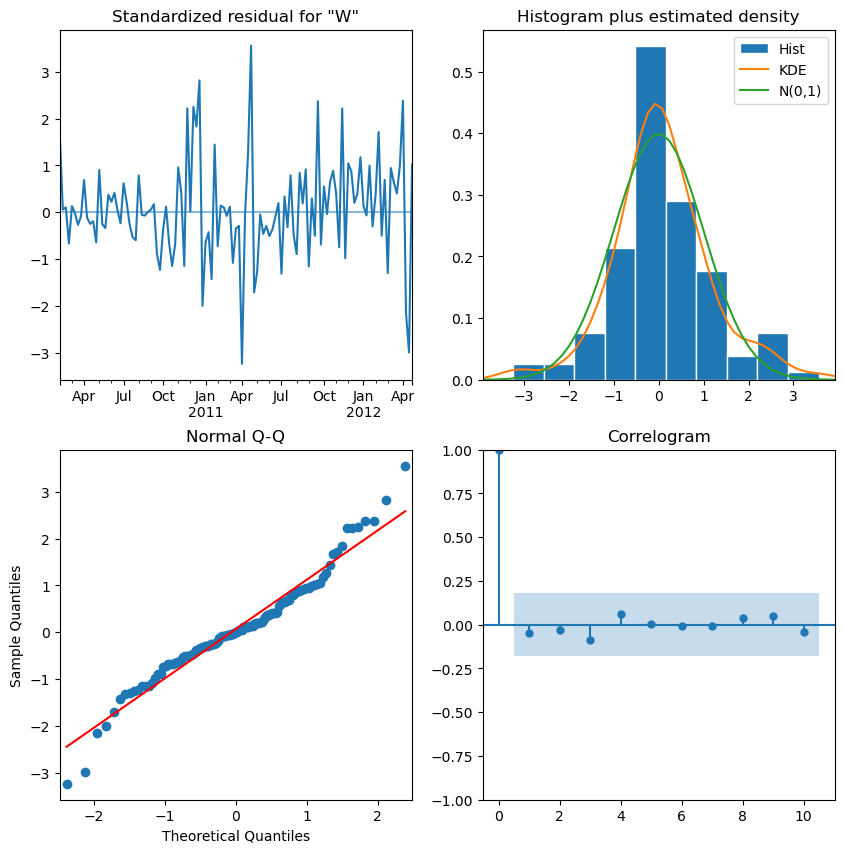

In [77]:
results.plot_diagnostics(figsize=(10,10))
plt.show()

In [78]:
#get the predictions and residuals
predictions = results.forecast(len(test))
predictions = pd.Series(predictions, index=test.index).to_frame(name='Weekly_Sales')
residuals = test - predictions

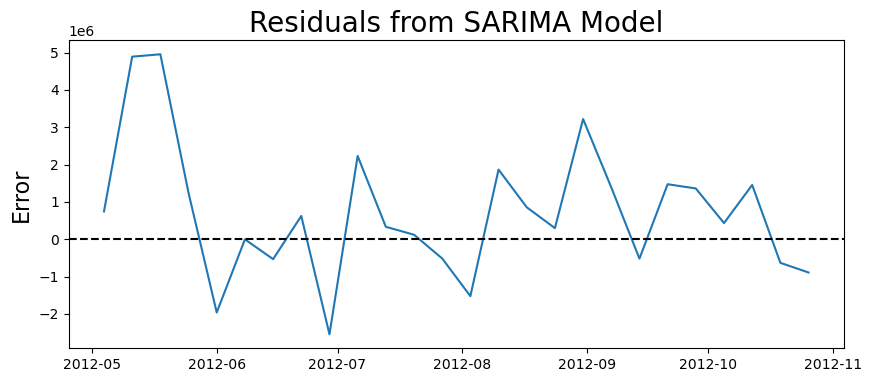

In [79]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title( 'Residuals from SARIMA Model' ,fontsize=20)
plt.ylabel( 'Error', fontsize=16)
plt.show()

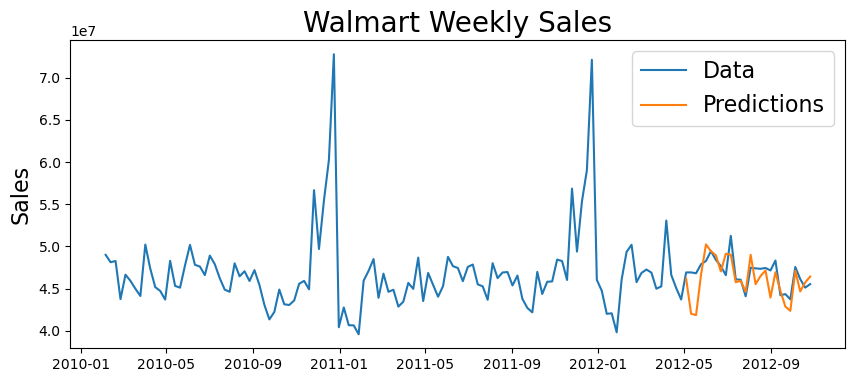

In [80]:
plt.figure(figsize=(10,4))
plt.plot(cum_pdf)
plt.plot(predictions)

plt.legend(('Data','Predictions'), fontsize=16)

plt.title('Walmart Weekly Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.show()

In [81]:
print('MAPE: ', round(np.mean(abs(residuals/test)),4))
# The mean absolute error
mae = np.mean(np.abs(residuals))
print("Mean Absolute Error: ", mae)
print('Root Mean Squared Error: ', round(np.sqrt(np.mean(residuals**2)),2))

MAPE:  0.03
Mean Absolute Error:  1408350.6661429098
Root Mean Squared Error:  1897932.7
